In [ ]:
# # IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# # RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
# import kagglehub
# kagglehub.login()


In [ ]:
# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.

# ariel_data_challenge_2024_path = kagglehub.competition_download('ariel-data-challenge-2024')

# print('Data source import complete.')


ref: https://www.kaggle.com/code/gordonyip/update-calibrating-and-binning-astronomical-data?scriptVersionId=194563765

# Calibrating and Time Binning Astronomical Data

**UPDATE 14.08**: We have updated the calibration steps in the notebook. We understand that some of you have been using the old calibration procedure. The old procedures still provide a good estimate of the transit depth over different wavelengths, but as competition hosts we understand the difficulty to accurately calibrate the data product (even for us, it is still a learning journey, afterall, we are preparing for the mission), and we want to make sure you have the most updated knowledge on the calibration pipeline, so that it helps your journey in tackling this challenge. We will explain more in our discussion

**UPDATE 29.08**: We have added 0.1s to the integration time for both AIRS and FGS observations. They are important when accounting for the contributing of dark frames when calibration the image. The modification, however, should not affect too much of the calibrated product.

Data reduction is crucial in astronomical observations, and this challenge is no exception. This notebook outlines essential calibration steps typically employed by astronomers to mitigate noise in data.

Key points:

- The notebook guides participants through pre-processing data and saving it in a more convenient, lighter format.
- If you plan to use the baseline models (which will be released soon), you must run this notebook first before training.

Important note: While these steps help reduce noise and data size, they may not be the most effective approach for achieving the optimal model for this challenge. Participants are encouraged to explore alternative methods that could yield better results.





**Acknowledgement**: This notebook is prepared by Angèle Syty and Virginie Batista (IAP), with support from Andrea Bocchieri, Orphée Faucoz (CNES), Lorenzo V. Mugnai (Cardiff University & UCL), Tara Tahseen (UCL), Gordon Yip (UCL).

Last modified: 29 Aug 2024.

In [32]:
import numpy as np
import pandas as pd
import itertools
import os
import glob
from astropy.stats import sigma_clip

from tqdm import tqdm
import matplotlib.pyplot as plt




Below, we define the corrections we want to apply, the size of the data chunks and the different path used to import data and save the light ones.

In [8]:
# myvenv
path_folder = '/home/ulaval.ca/maelr5/scratch/ariel-data-challenge'#path to the folder containing the data#'/kaggle/input/ariel-data-challenge-2024/'
path_out = '/home/ulaval.ca/maelr5/scratch/data_light_raw_sample/' # path to the folder to store the light data#'/kaggle/tmp/data_light_raw/'
output_dir = '/home/ulaval.ca/maelr5/scratch/data_light_raw_sample/' # path for the output directory#'/kaggle/tmp/data_light_raw/'



If the *path_out* folder doesn't exist yet, it is created.

In [9]:
if not os.path.exists(path_out):
    os.makedirs(path_out)
    print(f"Directory {path_out} created.")
else:
    print(f"Directory {path_out} already exists.")


Directory /home/ulaval.ca/maelr5/scratch/data_light_raw_sample/ already exists.


**Data import:**

 The files are imported by chunks of size 'CHUNK_SIZE' to avoid exceeding the memory capacity.

In [10]:
CHUNKS_SIZE = 1



## Step 1: Analog-to-Digital Conversion

The Analog-to-Digital Conversion (adc) is performed by the detector to convert the pixel voltage into an integer number. We revert this operation by using the gain and offset for the calibration files 'train_adc_info.csv'.


In [12]:
def ADC_convert(signal, gain, offset):
    signal = signal.astype(np.float64)
    signal /= gain
    signal += offset
    return signal



## Step 2: Mask hot/dead pixel
The dead pixels map is a map of the pixels that do not respond to light and, thus, can’t be accounted for any calculation. In all these frames the dead pixels are masked using python masked arrays. The bad pixels are thus masked but left uncorrected. Some methods can be used to correct bad-pixels but this task, if needed, is left to the participants.

In [13]:
def mask_hot_dead(signal, dead, dark):
    hot = sigma_clip(
        dark, sigma=5, maxiters=5
    ).mask
    hot = np.tile(hot, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))
    signal = np.ma.masked_where(dead, signal)
    signal = np.ma.masked_where(hot, signal)
    return signal



## Step 2: linearity Correction



**Non-linearity of pixels' response:**

The non-linearity of the pixels’ response can be explained as capacitive leakage on the readout electronics of each pixel during the integration time. The number of electrons in the well is proportional to the number of photons that hit the pixel, with a quantum efficiency coefficient. However, the response of the pixel is not linear with the number of electrons in the well. This effect can be described by a polynomial function of the number of electrons actually in the well. The data is provided with calibration files linear_corr.parquet that are the coefficients of the inverse polynomial function and can be used to correct this non-linearity effect.



In [14]:
def apply_linear_corr(linear_corr,clean_signal):
    linear_corr = np.flip(linear_corr, axis=0)
    for x, y in itertools.product(
                range(clean_signal.shape[1]), range(clean_signal.shape[2])
            ):
        poli = np.poly1d(linear_corr[:, x, y])
        clean_signal[:, x, y] = poli(clean_signal[:, x, y])
    return clean_signal




## Step 3: dark current subtraction

The data provided include calibration for dark current estimation, which can be used to pre-process the observations. Dark current represents a constant signal that accumulates in each pixel during the integration time, independent of the incoming light. To obtain the corrected image, the following conventional approach is applied: The data provided include calibration files such as dark frames or dead pixels' maps. They can be used to pre-process the observations. The dark frame is a map of the detector response to a very short exposure time, to correct for the dark current of the detector.
$$\text{image - dark} \times \Delta t $$
The corrected image is conventionally obtained via the following: where the dark current map is first corrected for the dead pixel.

In [15]:
def clean_dark(signal, dead, dark, dt):

    dark = np.ma.masked_where(dead, dark)
    dark = np.tile(dark, (signal.shape[0], 1, 1))

    signal -= dark* dt[:, np.newaxis, np.newaxis]
    return signal



## Step 4: Get Correlated Double Sampling (CDS)

The science frames are alternating between the start of the exposure and the end of the exposure. The lecture scheme is a ramp with a double sampling, called Correlated Double Sampling (CDS), the detector is read twice, once at the start of the exposure and once at the end of the exposure. The final CDS is the difference (End of exposure) - (Start of exposure).

In [16]:
def get_cds(signal):
    cds = signal[:,1::2,:,:] - signal[:,::2,:,:]
    return cds



## Step 5 (Optional): Time Binning
This step is performed mianly to save space. Time series observations are binned together at specified frequency.



In [17]:
def bin_obs(cds_signal,binning):
    cds_transposed = cds_signal.transpose(0,1,3,2)
    cds_binned = np.zeros((cds_transposed.shape[0], cds_transposed.shape[1]//binning, cds_transposed.shape[2], cds_transposed.shape[3]))
    for i in range(cds_transposed.shape[1]//binning):
        cds_binned[:,i,:,:] = np.sum(cds_transposed[:,i*binning:(i+1)*binning,:,:], axis=1)
    return cds_binned


## Step 6: Flat Field Correction


The flat field is a map of the detector response to uniform illumination, to correct for the pixel-to-pixel variations of the detector, for example the different quantum efficiencies of each pixel.

In [18]:
def correct_flat_field(flat,dead, signal):
    flat = flat.transpose(1, 0)
    dead = dead.transpose(1, 0)
    flat = np.ma.masked_where(dead, flat)
    flat = np.tile(flat, (signal.shape[0], 1, 1))
    signal = signal / flat
    return signal



# Calibrating all training data

you can choose to correct the non-linearity of the pixels' response, to apply flat field, dark and dead map or to leave the data unchanged. The observations are binned in time by group of 30 frames for AIRS and 360 frames for FGS1, to obtain a lighter data-cube, easier to use. The images are cut along the wavelength axis between pixels 39 and 321, so that the 282 pixels left in the wavelength dimension match the last 282 targets' points, from AIRS. The 283rd targets' point is the one for FGS1 that will be added later on.

In [19]:
## we will start by getting the index of the training data:
def get_index(files,CHUNKS_SIZE):
    index = []
    # print(len(files))
    for file in files :
        file_name = file.split('/')[-1]
        # print(file_index, file_name)
        if file_name.split('_')[0] == 'AIRS-CH0' and file_name.split('_')[1] == 'signal.parquet':
            file_index = os.path.basename(os.path.dirname(file))
            # print(file_index, file)
            index.append(int(file_index))
    index = np.array(index)
    index = np.sort(index)
    # credit to DennisSakva
    index=np.array_split(index, len(index)//CHUNKS_SIZE)

    return index


In [20]:
print(os.path.join(path_folder + '/train/', '*/*'))
files = glob.glob(os.path.join(path_folder + '/train/', '*/*'))
print(len(files))



/home/ulaval.ca/maelr5/scratch/ariel-data-challenge/train/*/*
2692


In [21]:
# files = glob.glob(os.path.join(path_folder + '/train/', '*/*'))
# print('number of train files= ', len(files))



In [36]:
index = get_index(files[60-4:60],CHUNKS_SIZE)
index



[array([3932146472])]

In [37]:
path_folder, index[0][0]

('/home/ulaval.ca/maelr5/scratch/ariel-data-challenge', 3932146472)

In [38]:

train_adc_info = pd.read_csv(os.path.join(path_folder, 'train_adc_info.csv'))
train_adc_info = train_adc_info.set_index('planet_id')
axis_info = pd.read_parquet(os.path.join(path_folder,'axis_info.parquet'))

print('train_adc_info ', train_adc_info.shape, 'axis_info ', axis_info.shape)
print(train_adc_info.head())
print(axis_info.head())


train_adc_info  (673, 5) axis_info  (135000, 4)
           FGS1_adc_offset  FGS1_adc_gain  AIRS-CH0_adc_offset  \
planet_id                                                        
785834         -343.335938       0.837244          -778.916533   
14485303       -366.381992       0.842983          -740.323212   
17002355       -386.107037       1.041701          -808.690659   
24135240       -339.737490       0.840239          -776.124167   
25070640       -355.660433       1.041280          -848.371494   

           AIRS-CH0_adc_gain  star  
planet_id                           
785834              0.924746     1  
14485303            0.931727     1  
17002355            1.513541     0  
24135240            0.931277     1  
25070640            1.503923     0  
   AIRS-CH0-axis0-h  AIRS-CH0-axis2-um  AIRS-CH0-integration_time  \
0          0.000028           4.078463                        0.1   
1          0.000056           4.074023                        4.5   
2          0.001361    

/home/ulaval.ca/maelr5/astronomy/MLSP-Project/myvenv/lib/python3.11/site-packages/fastparquet/dataframe.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):


In [39]:
df = pd.read_parquet(os.path.join(path_folder,f'train/2291997915/AIRS-CH0_signal.parquet'))
print(df.shape, df.values.shape)
df.head()



/home/ulaval.ca/maelr5/astronomy/MLSP-Project/myvenv/lib/python3.11/site-packages/fastparquet/dataframe.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):


(11250, 11392) (11250, 11392)


,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_11382,column_11383,column_11384,column_11385,column_11386,column_11387,column_11388,column_11389,column_11390,column_11391
0,719,733,713,751,721,723,749,694,729,758,...,767,729,745,744,744,732,745,754,734,732
1,758,724,732,710,708,770,740,743,731,736,...,738,705,727,727,731,749,759,750,732,741
2,735,736,732,737,719,723,738,730,731,738,...,731,717,723,756,736,749,728,736,732,758
3,730,734,731,729,702,749,741,715,745,758,...,745,721,756,740,728,743,744,716,771,751
4,730,723,732,753,737,750,752,732,738,738,...,727,738,735,724,733,731,726,730,737,732


In [40]:

DO_MASK = True
DO_THE_NL_CORR = False
DO_DARK = True
DO_FLAT = True
TIME_BINNING = True

cut_inf, cut_sup = 39, 321
l = cut_sup - cut_inf

steps = ['Input Signal', 'ADC', 'Mask Hot/Dead Pixels', 'Dark Current Subtraction', 'CDS', 'Time Binning', 'Flat Field Correction']
# Get Correlated Double Sampling (CDS)
visualize_AIRS = {}
visualize_FGS1 = {}

for n, index_chunk in enumerate(tqdm(index)):
    print(n, index_chunk)
    AIRS_CH0_clean = np.zeros((CHUNKS_SIZE, 11250, 32, l))
    FGS1_clean = np.zeros((CHUNKS_SIZE, 135000, 32, 32))

    for i in range (CHUNKS_SIZE):
        df = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_signal.parquet'))
        signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 356))
        print('AIRSsignal before sum over spatial dim ', signal.shape)
        print('AIRSsignal after sum over spatial dim 1 ', signal.sum(axis=1).shape)
        visualize_AIRS[n] = [signal] #**********************************************
        
        gain = train_adc_info['AIRS-CH0_adc_gain'].loc[index_chunk[i]]
        offset = train_adc_info['AIRS-CH0_adc_offset'].loc[index_chunk[i]]
        signal = ADC_convert(signal, gain, offset)
        dt_airs = axis_info['AIRS-CH0-integration_time'].dropna().values
        dt_airs[1::2] += 0.1
        chopped_signal = signal[:, :, cut_inf:cut_sup]
        print('ADC_fgs_signal before sum over spatial dim ', chopped_signal.shape)
        print('ADC_fgs_signal after sum over spatial dim 1 ', chopped_signal.sum(axis=1).shape)
        visualize_AIRS[n].append(chopped_signal) #**********************************************
        del signal, df

        # CLEANING THE DATA: AIRS
        flat = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/dark.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        dead_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/dead.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 356))[:, :, cut_inf:cut_sup]

        if DO_MASK:
            chopped_signal = mask_hot_dead(chopped_signal, dead_airs, dark)
            AIRS_CH0_clean[i] = chopped_signal
            print('D/H masked/ AIRS_CH0_clean before sum over spatial dim ', AIRS_CH0_clean[i].shape)
            print('D/H masked/ AIRS_CH0_clean after sum over spatial dim 1 ', AIRS_CH0_clean[i].sum(axis=1).shape)
            visualize_AIRS[n].append(AIRS_CH0_clean[i])#**********************************************
        else:
            AIRS_CH0_clean[i] = chopped_signal

        if DO_THE_NL_CORR:
            linear_corr_signal = apply_linear_corr(linear_corr,AIRS_CH0_clean[i])
            AIRS_CH0_clean[i,:, :, :] = linear_corr_signal
            print('linear corr/ AIRS_CH0_clean before sum over spatial dim ', AIRS_CH0_clean[i].shape)
            print('linear corr/ AIRS_CH0_clean after sum over spatial dim 1', AIRS_CH0_clean[i].sum(axis=1).shape)
            visualize_AIRS[n].append(AIRS_CH0_clean[i])#**********************************************
        del linear_corr

        if DO_DARK:
            cleaned_signal = clean_dark(AIRS_CH0_clean[i], dead_airs, dark, dt_airs)
            AIRS_CH0_clean[i] = cleaned_signal
            print('dark_cleaned_signal/ AIRS_CH0_clean before sum over spatial dim ', AIRS_CH0_clean[i].shape)
            print('dark_cleaned_signal/ AIRS_CH0_clean after sum over spatial dim 1', AIRS_CH0_clean[i].sum(axis=1).shape)
            visualize_AIRS[n].append(AIRS_CH0_clean[i])#**********************************************
        else:
            pass
        del dark

        df = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_signal.parquet'))
        fgs_signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 32))
        print('fgs_signal before sum over spatial dim ', fgs_signal.shape)
        print('fgs_signal after sum over spatial dim 1 ', fgs_signal.sum(axis=1).shape)
        visualize_FGS1[n] = [fgs_signal] #**********************************************

        FGS1_gain = train_adc_info['FGS1_adc_gain'].loc[index_chunk[i]]
        FGS1_offset = train_adc_info['FGS1_adc_offset'].loc[index_chunk[i]]

        fgs_signal = ADC_convert(fgs_signal, FGS1_gain, FGS1_offset)
        dt_fgs1 = np.ones(len(fgs_signal))*0.1
        dt_fgs1[1::2] += 0.1
        chopped_FGS1 = fgs_signal
        print('ADC_fgs_signal before sum over spatial dim ', chopped_FGS1.shape)
        print('ADC_fgs_signal after sum over spatial dim 1 ', chopped_FGS1.sum(axis=1).shape)
        visualize_FGS1[n].append(chopped_FGS1) #**********************************************
        del fgs_signal, df

        # CLEANING THE DATA: FGS1
        flat = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 32))
        dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/dark.parquet')).values.astype(np.float64).reshape((32, 32))
        dead_fgs1 = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/dead.parquet')).values.astype(np.float64).reshape((32, 32))
        linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 32))

        if DO_MASK:
            chopped_FGS1 = mask_hot_dead(chopped_FGS1, dead_fgs1, dark)
            FGS1_clean[i] = chopped_FGS1
            print('D/H masked/ FGS1_clean before sum over spatial dim ', FGS1_clean[i].shape)
            print('D/H masked/ FGS1_clean after sum over spatial dim 1 ', FGS1_clean[i].sum(axis=1).shape)
            visualize_FGS1[n].append(FGS1_clean[i]) #**********************************************
        else:
            FGS1_clean[i] = chopped_FGS1

        if DO_THE_NL_CORR:
            linear_corr_signal = apply_linear_corr(linear_corr,FGS1_clean[i])
            FGS1_clean[i,:, :, :] = linear_corr_signal
            print('linear_corr/ FGS1_clean before sum over spatial dim ', FGS1_clean[i].shape)
            print('linear_corr/ FGS1_clean after sum over spatial dim 1 ', FGS1_clean[i].sum(axis=1).shape)
            visualize_FGS1[n].append(FGS1_clean[i]) #**********************************************
        del linear_corr

        if DO_DARK:
            cleaned_signal = clean_dark(FGS1_clean[i], dead_fgs1, dark,dt_fgs1)
            FGS1_clean[i] = cleaned_signal
            print('dark_cleaned/ FGS1_clean before sum over spatial dim ', FGS1_clean[i].shape)
            print('dark_cleaned/ FGS1_clean after sum over spatial dim 1 ', FGS1_clean[i].sum(axis=1).shape)
            visualize_FGS1[n].append(FGS1_clean[i]) #**********************************************
        else:
            pass
        del dark

    # SAVE DATA AND FREE SPACE
    AIRS_cds = get_cds(AIRS_CH0_clean)
    FGS1_cds = get_cds(FGS1_clean)
    print('before sum over spatial dim ', 'AIRS_cds ', AIRS_cds[i].shape, 'FGS1_cds ', FGS1_cds[i].shape)
    print('after sum over spatial dim 1 ', 'AIRS_cds ', AIRS_cds[i].sum(axis=1).shape, 'FGS1_cds ', FGS1_cds[i].sum(axis=1).shape)
    visualize_AIRS[n].append(AIRS_cds[i])#**********************************************
    visualize_FGS1[n].append(FGS1_cds[i]) #**********************************************

    del AIRS_CH0_clean, FGS1_clean

    ## (Optional) Time Binning to reduce space
    if TIME_BINNING:
        AIRS_cds_binned = bin_obs(AIRS_cds,binning=30)
        FGS1_cds_binned = bin_obs(FGS1_cds,binning=30*12)
    else:
        AIRS_cds = AIRS_cds.transpose(0,1,3,2) ## this is important to make it consistent for flat fielding, but you can always change it
        AIRS_cds_binned = AIRS_cds
        FGS1_cds = FGS1_cds.transpose(0,1,3,2)
        FGS1_cds_binned = FGS1_cds
    print('before sum over spatial dim ', 'AIRS_cds_binned ', AIRS_cds_binned.shape, 'FGS1_cds_binned ', FGS1_cds_binned.shape)
    print('after sum over spatial dim 2 ', 'AIRS_cds_binned ', AIRS_cds_binned[i].sum(axis=2).shape, 'FGS1_cds_binned ', FGS1_cds_binned[i].sum(axis=2).shape)
    visualize_AIRS[n].append(AIRS_cds_binned[i])#**********************************************
    visualize_FGS1[n].append(FGS1_cds_binned[i]) #**********************************************

    del AIRS_cds, FGS1_cds

    for i in range (CHUNKS_SIZE):
        flat_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        flat_fgs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 32))
        if DO_FLAT:
            corrected_AIRS_cds_binned = correct_flat_field(flat_airs,dead_airs, AIRS_cds_binned[i])
            AIRS_cds_binned[i] = corrected_AIRS_cds_binned
            corrected_FGS1_cds_binned = correct_flat_field(flat_fgs,dead_fgs1, FGS1_cds_binned[i])
            FGS1_cds_binned[i] = corrected_FGS1_cds_binned
        else:
            pass
        print('before sum over spatial dim ', 'flat_AIRS_cds_binned ', AIRS_cds_binned.shape, 'flat_FGS1_cds_binned ', FGS1_cds_binned.shape)
        print('after sum over spatial dim 2 ', 'flat_AIRS_cds_binned ', AIRS_cds_binned[i].sum(axis=2).shape, 'flat_FGS1_cds_binned ', FGS1_cds_binned[i].sum(axis=2).shape)
        visualize_AIRS[n].append(AIRS_cds_binned[i])#**********************************************
        visualize_FGS1[n].append(FGS1_cds_binned[i]) #**********************************************

    ## save data
    # np.save(os.path.join(path_out, 'AIRS_clean_train_{}.npy'.format(n)), AIRS_cds_binned)
    # np.save(os.path.join(path_out, 'FGS1_train_{}.npy'.format(n)), FGS1_cds_binned)
    # del AIRS_cds_binned
    # del FGS1_cds_binned

  0%|          | 0/1 [00:00<?, ?it/s]

0 [3932146472]


/home/ulaval.ca/maelr5/astronomy/MLSP-Project/myvenv/lib/python3.11/site-packages/fastparquet/dataframe.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):


AIRSsignal before sum over spatial dim  (11250, 32, 356)
AIRSsignal after sum over spatial dim 1  (11250, 356)
ADC_fgs_signal before sum over spatial dim  (11250, 32, 282)
ADC_fgs_signal after sum over spatial dim 1  (11250, 282)
D/H masked/ AIRS_CH0_clean before sum over spatial dim  (11250, 32, 282)
D/H masked/ AIRS_CH0_clean after sum over spatial dim 1  (11250, 282)
dark_cleaned_signal/ AIRS_CH0_clean before sum over spatial dim  (11250, 32, 282)
dark_cleaned_signal/ AIRS_CH0_clean after sum over spatial dim 1 (11250, 282)


/home/ulaval.ca/maelr5/astronomy/MLSP-Project/myvenv/lib/python3.11/site-packages/fastparquet/dataframe.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):


fgs_signal before sum over spatial dim  (135000, 32, 32)
fgs_signal after sum over spatial dim 1  (135000, 32)
ADC_fgs_signal before sum over spatial dim  (135000, 32, 32)
ADC_fgs_signal after sum over spatial dim 1  (135000, 32)
D/H masked/ FGS1_clean before sum over spatial dim  (135000, 32, 32)
D/H masked/ FGS1_clean after sum over spatial dim 1  (135000, 32)
dark_cleaned/ FGS1_clean before sum over spatial dim  (135000, 32, 32)
dark_cleaned/ FGS1_clean after sum over spatial dim 1  (135000, 32)
before sum over spatial dim  AIRS_cds  (5625, 32, 282) FGS1_cds  (67500, 32, 32)
after sum over spatial dim 1  AIRS_cds  (5625, 282) FGS1_cds  (67500, 32)


/home/ulaval.ca/maelr5/astronomy/MLSP-Project/myvenv/lib/python3.11/site-packages/fastparquet/dataframe.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
100%|██████████| 1/1 [00:16<00:00, 16.68s/it]

before sum over spatial dim  AIRS_cds_binned  (1, 187, 282, 32) FGS1_cds_binned  (1, 187, 32, 32)
after sum over spatial dim 2  AIRS_cds_binned  (187, 282) FGS1_cds_binned  (187, 32)
before sum over spatial dim  flat_AIRS_cds_binned  (1, 187, 282, 32) flat_FGS1_cds_binned  (1, 187, 32, 32)
after sum over spatial dim 2  flat_AIRS_cds_binned  (187, 282) flat_FGS1_cds_binned  (187, 32)


In [41]:
print(len(steps), len(visualize_AIRS[n]), len(visualize_FGS1[n]))



7 7 7


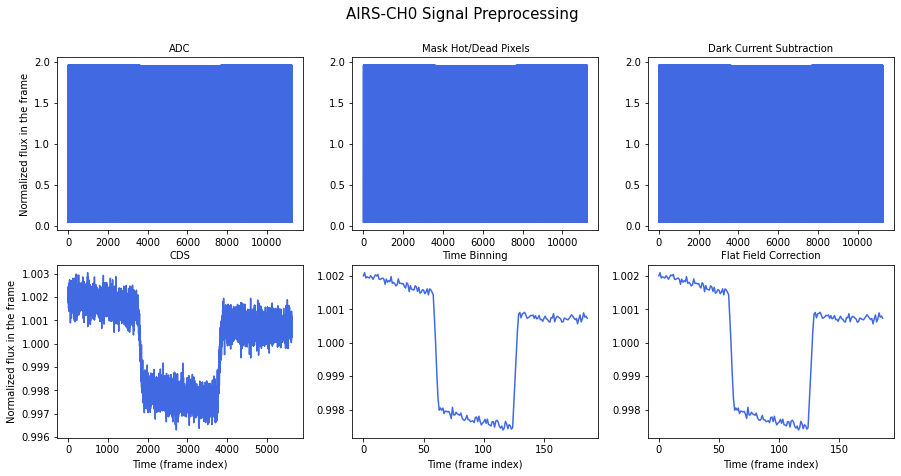

In [50]:

# plt.figure(figsize=(5,3))
# lc = visualize_AIRS[n][0].sum(axis=(1,2))
# plt.plot(lc/lc.mean(), c='royalblue')
# plt.title(f'AIRS-CH0 Input Signal {index[0][0]}')
# plt.show()


fig, axs = plt.subplots(2, 3, figsize=(15, 7))
i=1
axs = axs.flatten()
for ax in axs:
    lc = visualize_AIRS[n][i].sum(axis=(1,2))
    ax.plot(lc/lc.mean(), c='royalblue')
    ax.set_title(steps[i], fontsize=10)
    if i in ([1,4]):
        ax.set(ylabel='Normalized flux in the frame')
    if i in ([4,5,6]):
        ax.set(xlabel='Time (frame index)')
    # ax.grid(True)
    i+=1
plt.suptitle('AIRS-CH0 Signal Preprocessing', fontsize=15)
plt.show()



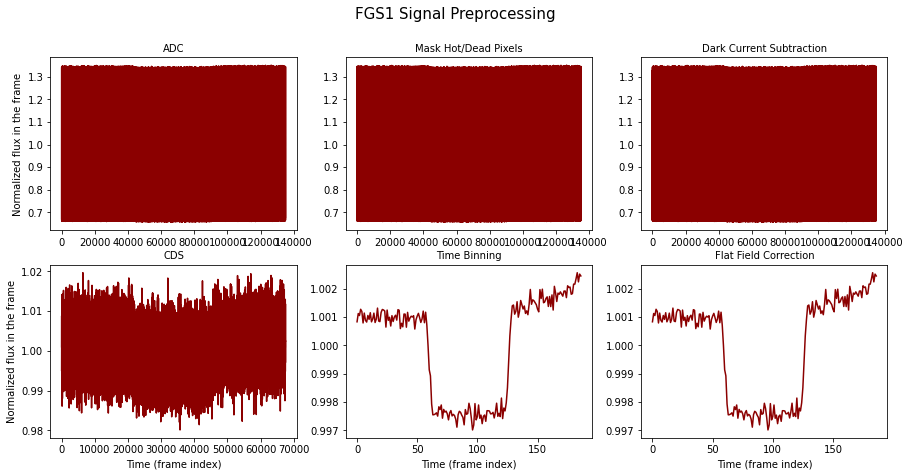

In [52]:
# plt.figure(figsize=(5,3))
# lc = visualize_FGS1[n][0].sum(axis=(1,2))
# plt.plot(lc/lc.mean(), c='darkred')
# plt.title(f'FGS1 Input Signal {index[0][0]}')
# plt.show()


fig, axs = plt.subplots(2, 3, figsize=(15, 7))
i=1
axs = axs.flatten()
for ax in axs:
    lc = visualize_FGS1[n][i].sum(axis=(1,2))
    ax.plot(lc/lc.mean(), c='darkred')
    ax.set_title(steps[i], fontsize=10)
    if i in ([1,4]):
        ax.set(ylabel='Normalized flux in the frame')
    if i in ([4,5,6]):
        ax.set(xlabel='Time (frame index)')
    # ax.grid(True)
    i+=1
plt.suptitle('FGS1 Signal Preprocessing', fontsize=15)
plt.show()





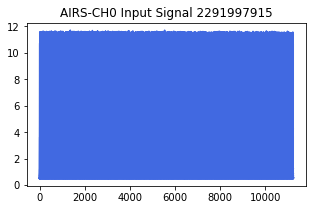

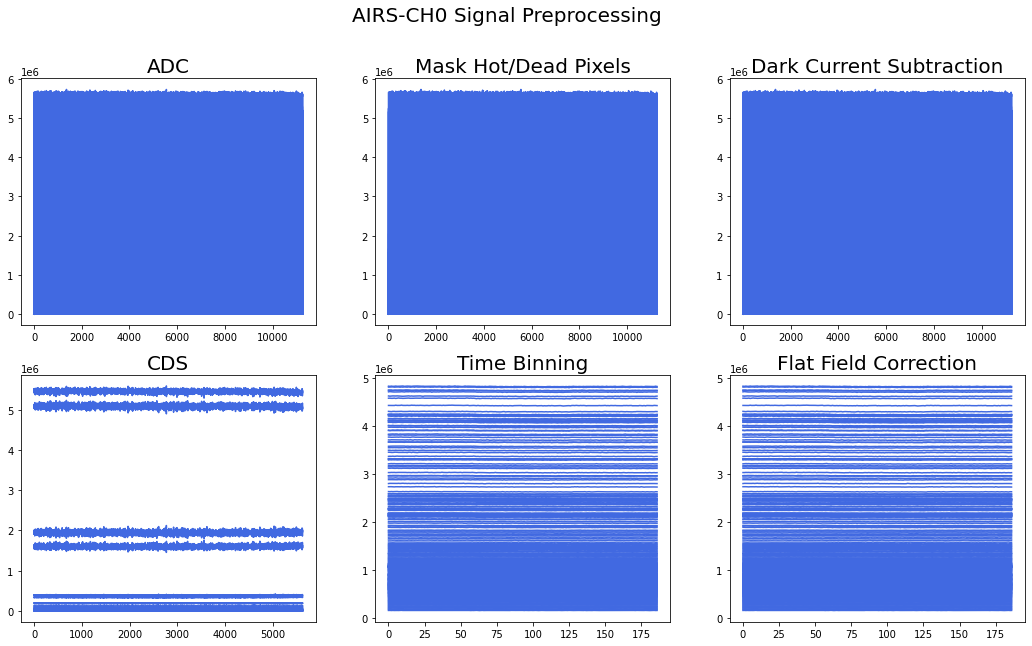

In [34]:

plt.figure(figsize=(5,3))
lc = visualize_AIRS[n][0].sum(axis=(2))
plt.plot(lc/lc.mean(), c='royalblue')
plt.title(f'AIRS-CH0 Input Signal {index[0][0]}')
plt.show()


fig, axs = plt.subplots(2, 3, figsize=(18, 10))
i=1
axs = axs.flatten()
for ax in axs:
    lc = visualize_AIRS[n][i].sum(axis=(2))
    ax.plot(lc, c='royalblue')
    ax.set_title(steps[i], fontsize=20)
    # ax.grid(True)
    i+=1
plt.suptitle('AIRS-CH0 Signal Preprocessing', fontsize=20)
plt.show()



data shape=  (1, 187, 283, 32)


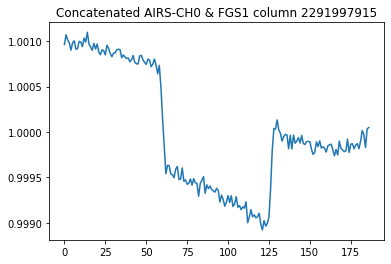

In [61]:
# sum FGS over the wavelength dim and concatenate with AIRS-CH0 over the wavelength dim
FGS_column = FGS1_cds_binned.sum(axis = 2)
dataset = np.concatenate([AIRS_cds_binned, FGS_column[:,:, np.newaxis,:]], axis = 2)
print('data shape= ', dataset.shape)

lc = dataset[0].sum(axis=(1,2))
plt.plot(lc/lc.mean())
plt.title(f'Concatenated AIRS-CH0 & FGS1 column {index[0][0]}')
plt.show()



Once all the chunks are saved, we concatenate them back in a single dataset. This step is simply to save HDD space, modify it as you wish.

In [44]:
def load_data (file, chunk_size, nb_files) :
    data0 = np.load(file + '_0.npy')
    data_all = np.zeros((nb_files*chunk_size, data0.shape[1], data0.shape[2], data0.shape[3]))
    data_all[:chunk_size] = data0
    for i in range (1, nb_files) :
        data_all[i*chunk_size:(i+1)*chunk_size] = np.load(file + '_{}.npy'.format(i))
    return data_all

data_train = load_data(path_out + 'AIRS_clean_train', CHUNKS_SIZE, len(index))
data_train_FGS = load_data(path_out + 'FGS1_train', CHUNKS_SIZE, len(index))


In [46]:
# np.save('/home/ulaval.ca/maelr5/scratch/binned-dataset-v1/' + 'data_train.npy', data_train) #/kaggle/working/
# np.save('/home/ulaval.ca/maelr5/scratch/binned-dataset-v1/' + 'data_train_FGS.npy', data_train_FGS)# /kaggle/working/
# # binned-dataset-v3


# Plots

Let us checks that everything went well during the data import.

In [1]:
import matplotlib.pyplot as plt

print('Shape of the training datasset: \t')
print('\n For AIRS-CH0:', data_train.shape)
print('\n For FGS1:', data_train_FGS.shape)



Shape of the training datasset: 	


NameError: name 'data_train' is not defined

Plot of some images:

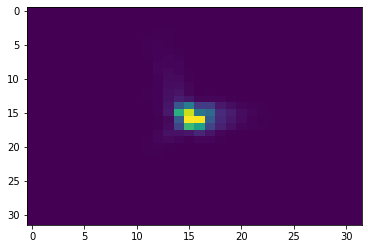

In [47]:
plt.imshow(data_train_FGS[-1,50,:,:].T, aspect = 'auto')



Plot of some light-curves:

In [38]:
AIRS_cds_binned.shape, AIRS_cds_binned[0,:,:,:].sum(axis=(1,2)).shape



((1, 187, 282, 32), (187,))

Text(0, 0.5, 'Normalized flux in the frame')

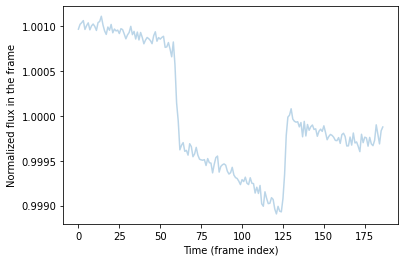

In [37]:

# for i in range(len(data_train)) :
light_curve = AIRS_cds_binned[0,:,:,:].sum(axis=(1,2))
plt.plot(light_curve/light_curve.mean(), '-', alpha=0.3)

plt.xlabel('Time (frame index)')
plt.ylabel('Normalized flux in the frame')



In [54]:
data_folder = '/home/ulaval.ca/maelr5/scratch/binned-dataset-v1/'
data_train_AIRS = np.load(f'{data_folder}/data_train.npy')
data_train_FGS = np.load(f'{data_folder}/data_train_FGS.npy')
print(data_train_AIRS.shape, data_train_FGS.shape)




(673, 187, 282, 32) (673, 187, 32, 32)


In [ ]:
lc = data_train_AIRS[15].sum(axis=(1,2))
plt.plot(lc/lc.mean())
plt.title(f'AIRS-CH0 signal sample')
plt.show()




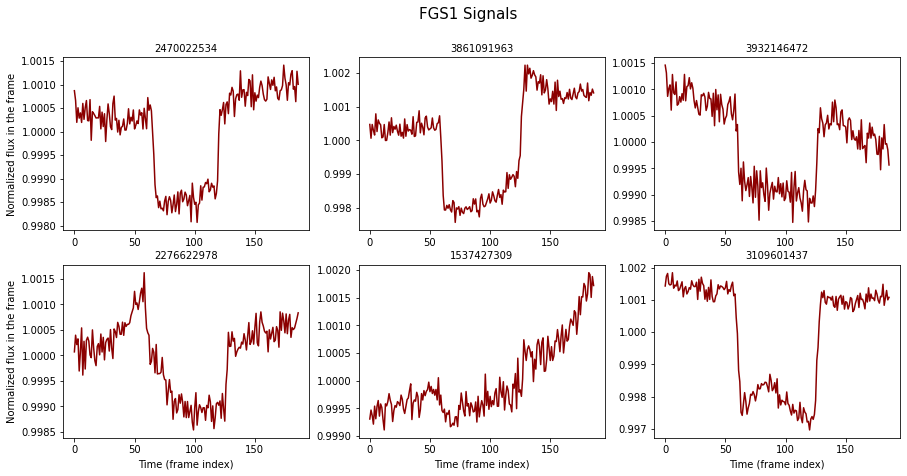

In [62]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
t = [4, 10, 15, 25, 35, 50]
i=0
axs = axs.flatten()
for ax in axs:
    lc = data_train_FGS[t[i]].sum(axis=(1,2))
    ax.plot(lc/lc.mean(), c='darkred')
    ax.set_title(f'{get_index(files[t[i]*4-4:t[i]*4],CHUNKS_SIZE)[0][0]}', fontsize=10)
    if i in ([0,3]):
        ax.set(ylabel='Normalized flux in the frame')
    if i in ([3,4,5]):
        ax.set(xlabel='Time (frame index)')
    # ax.grid(True)
    i+=1
plt.suptitle('FGS1 Signals', fontsize=15)
plt.show()




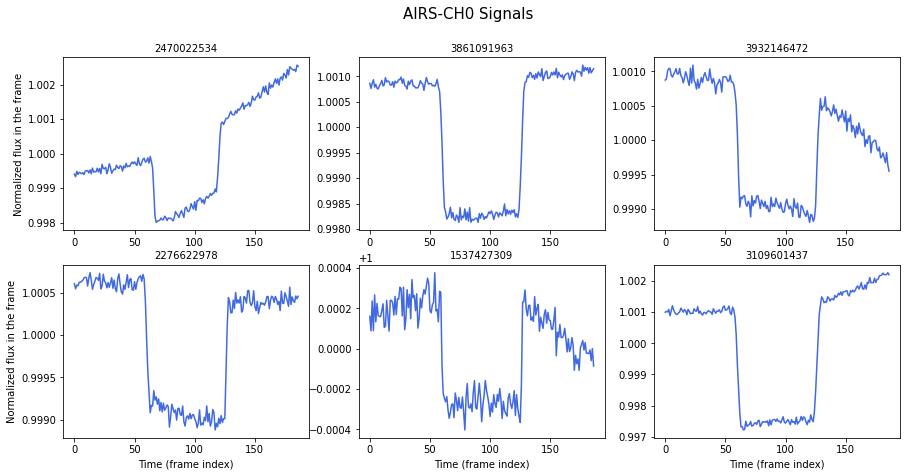

In [63]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
t = [4, 10, 15, 25, 35, 50]
i=0
axs = axs.flatten()
for ax in axs:
    lc = data_train_AIRS[t[i]].sum(axis=(1,2))
    ax.plot(lc/lc.mean(), c='royalblue')
    ax.set_title(f'{get_index(files[t[i]*4-4:t[i]*4],CHUNKS_SIZE)[0][0]}', fontsize=10)
    if i in ([0,3]):
        ax.set(ylabel='Normalized flux in the frame')
    if i in ([3,4,5]):
        ax.set(xlabel='Time (frame index)')
    # ax.grid(True)
    i+=1
plt.suptitle('AIRS-CH0 Signals', fontsize=15)
plt.show()




Text(0, 0.5, 'Normalized flux in the frame')

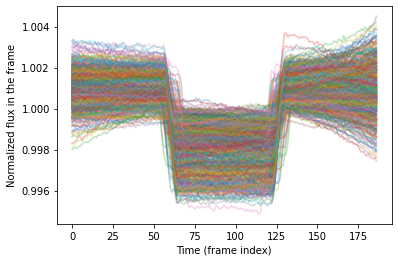

In [48]:

for i in range(len(data_train)) :
    light_curve = data_train[i,:,:,:].sum(axis=(1,2))
    plt.plot(light_curve/light_curve.mean(), '-', alpha=0.3)

plt.xlabel('Time (frame index)')
plt.ylabel('Normalized flux in the frame')



Text(0, 0.5, 'Normalized flux in the frame')

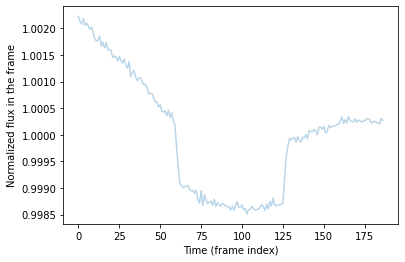

In [49]:
# for i in range(len(data_train)) :
light_curve = data_train[0,:,:,:].sum(axis=(1,2))
plt.plot(light_curve/light_curve.mean(), '-', alpha=0.3)

plt.xlabel('Time (frame index)')
plt.ylabel('Normalized flux in the frame')



In [21]:

# DO_MASK = True
# DO_THE_NL_CORR = False
# DO_DARK = True
# DO_FLAT = True
# TIME_BINNING = True

# cut_inf, cut_sup = 39, 321
# l = cut_sup - cut_inf

# # steps = ['Input Signal', 'ADC', 'Mask Hot/Dead Pixels', 'Dark Current Subtraction', 'CDS', 'Time Binning', 'Flat Field Correction']
# # Get Correlated Double Sampling (CDS)
# visualize_AIRS = {}
# visualize_FGS1 = {}

# for n, index_chunk in enumerate(tqdm(index)):
#     print(n, index_chunk)
#     AIRS_CH0_clean = np.zeros((CHUNKS_SIZE, 11250, 32, l))
#     FGS1_clean = np.zeros((CHUNKS_SIZE, 135000, 32, 32))

#     for i in range (CHUNKS_SIZE):
#         df = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_signal.parquet'))
#         signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 356))
#         print('AIRSsignal before sum over spatial dim ', signal.shape)
#         print('AIRSsignal after sum over spatial dim 1 ', signal.sum(axis=1).shape)
#         visualize_AIRS[n] = [signal.sum(axis=1)] #**********************************************
        
#         gain = train_adc_info['AIRS-CH0_adc_gain'].loc[index_chunk[i]]
#         offset = train_adc_info['AIRS-CH0_adc_offset'].loc[index_chunk[i]]
#         signal = ADC_convert(signal, gain, offset)
#         dt_airs = axis_info['AIRS-CH0-integration_time'].dropna().values
#         dt_airs[1::2] += 0.1
#         chopped_signal = signal[:, :, cut_inf:cut_sup]
#         print('ADC_fgs_signal before sum over spatial dim ', chopped_signal.shape)
#         print('ADC_fgs_signal after sum over spatial dim 1 ', chopped_signal.sum(axis=1).shape)
#         visualize_AIRS[n].append(chopped_signal.sum(axis=1)) #**********************************************
#         del signal, df

#         # CLEANING THE DATA: AIRS
#         flat = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
#         dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/dark.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
#         dead_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/dead.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
#         linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 356))[:, :, cut_inf:cut_sup]

#         if DO_MASK:
#             chopped_signal = mask_hot_dead(chopped_signal, dead_airs, dark)
#             AIRS_CH0_clean[i] = chopped_signal
#             print('D/H masked/ AIRS_CH0_clean before sum over spatial dim ', AIRS_CH0_clean[i].shape)
#             print('D/H masked/ AIRS_CH0_clean after sum over spatial dim 1 ', AIRS_CH0_clean[i].sum(axis=1).shape)
#             visualize_AIRS[n].append(AIRS_CH0_clean[i].sum(axis=1))#**********************************************
#         else:
#             AIRS_CH0_clean[i] = chopped_signal

#         if DO_THE_NL_CORR:
#             linear_corr_signal = apply_linear_corr(linear_corr,AIRS_CH0_clean[i])
#             AIRS_CH0_clean[i,:, :, :] = linear_corr_signal
#             print('linear corr/ AIRS_CH0_clean before sum over spatial dim ', AIRS_CH0_clean[i].shape)
#             print('linear corr/ AIRS_CH0_clean after sum over spatial dim 1', AIRS_CH0_clean[i].sum(axis=1).shape)
#             visualize_AIRS[n].append(AIRS_CH0_clean[i].sum(axis=1))#**********************************************
#         del linear_corr

#         if DO_DARK:
#             cleaned_signal = clean_dark(AIRS_CH0_clean[i], dead_airs, dark, dt_airs)
#             AIRS_CH0_clean[i] = cleaned_signal
#             print('dark_cleaned_signal/ AIRS_CH0_clean before sum over spatial dim ', AIRS_CH0_clean[i].shape)
#             print('dark_cleaned_signal/ AIRS_CH0_clean after sum over spatial dim 1', AIRS_CH0_clean[i].sum(axis=1).shape)
#             visualize_AIRS[n].append(AIRS_CH0_clean[i].sum(axis=1))#**********************************************
#         else:
#             pass
#         del dark

#         df = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_signal.parquet'))
#         fgs_signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 32))
#         print('fgs_signal before sum over spatial dim ', fgs_signal.shape)
#         print('fgs_signal after sum over spatial dim 1 ', fgs_signal.sum(axis=1).shape)
#         visualize_FGS1[n] = [fgs_signal.sum(axis=1)] #**********************************************

#         FGS1_gain = train_adc_info['FGS1_adc_gain'].loc[index_chunk[i]]
#         FGS1_offset = train_adc_info['FGS1_adc_offset'].loc[index_chunk[i]]

#         fgs_signal = ADC_convert(fgs_signal, FGS1_gain, FGS1_offset)
#         dt_fgs1 = np.ones(len(fgs_signal))*0.1
#         dt_fgs1[1::2] += 0.1
#         chopped_FGS1 = fgs_signal
#         print('ADC_fgs_signal before sum over spatial dim ', chopped_FGS1.shape)
#         print('ADC_fgs_signal after sum over spatial dim 1 ', chopped_FGS1.sum(axis=1).shape)
#         visualize_FGS1[n].append(chopped_FGS1.sum(axis=1)) #**********************************************
#         del fgs_signal, df

#         # CLEANING THE DATA: FGS1
#         flat = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 32))
#         dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/dark.parquet')).values.astype(np.float64).reshape((32, 32))
#         dead_fgs1 = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/dead.parquet')).values.astype(np.float64).reshape((32, 32))
#         linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 32))

#         if DO_MASK:
#             chopped_FGS1 = mask_hot_dead(chopped_FGS1, dead_fgs1, dark)
#             FGS1_clean[i] = chopped_FGS1
#             print('D/H masked/ FGS1_clean before sum over spatial dim ', FGS1_clean[i].shape)
#             print('D/H masked/ FGS1_clean after sum over spatial dim 1 ', FGS1_clean[i].sum(axis=1).shape)
#             visualize_FGS1[n].append(FGS1_clean[i].sum(axis=1)) #**********************************************
#         else:
#             FGS1_clean[i] = chopped_FGS1

#         if DO_THE_NL_CORR:
#             linear_corr_signal = apply_linear_corr(linear_corr,FGS1_clean[i])
#             FGS1_clean[i,:, :, :] = linear_corr_signal
#             print('linear_corr/ FGS1_clean before sum over spatial dim ', FGS1_clean[i].shape)
#             print('linear_corr/ FGS1_clean after sum over spatial dim 1 ', FGS1_clean[i].sum(axis=1).shape)
#             visualize_FGS1[n].append(FGS1_clean[i].sum(axis=1)) #**********************************************
#         del linear_corr

#         if DO_DARK:
#             cleaned_signal = clean_dark(FGS1_clean[i], dead_fgs1, dark,dt_fgs1)
#             FGS1_clean[i] = cleaned_signal
#             print('dark_cleaned/ FGS1_clean before sum over spatial dim ', FGS1_clean[i].shape)
#             print('dark_cleaned/ FGS1_clean after sum over spatial dim 1 ', FGS1_clean[i].sum(axis=1).shape)
#             visualize_FGS1[n].append(FGS1_clean[i].sum(axis=1)) #**********************************************
#         else:
#             pass
#         del dark

#     # SAVE DATA AND FREE SPACE
#     AIRS_cds = get_cds(AIRS_CH0_clean)
#     FGS1_cds = get_cds(FGS1_clean)
#     print('before sum over spatial dim ', 'AIRS_cds ', AIRS_cds[i].shape, 'FGS1_cds ', FGS1_cds[i].shape)
#     print('after sum over spatial dim 1 ', 'AIRS_cds ', AIRS_cds[i].sum(axis=1).shape, 'FGS1_cds ', FGS1_cds[i].sum(axis=1).shape)
#     visualize_AIRS[n].append(AIRS_cds[i].sum(axis=1))#**********************************************
#     visualize_FGS1[n].append(FGS1_cds[i].sum(axis=1)) #**********************************************

#     del AIRS_CH0_clean, FGS1_clean

#     ## (Optional) Time Binning to reduce space
#     if TIME_BINNING:
#         AIRS_cds_binned = bin_obs(AIRS_cds,binning=30)
#         FGS1_cds_binned = bin_obs(FGS1_cds,binning=30*12)
#     else:
#         AIRS_cds = AIRS_cds.transpose(0,1,3,2) ## this is important to make it consistent for flat fielding, but you can always change it
#         AIRS_cds_binned = AIRS_cds
#         FGS1_cds = FGS1_cds.transpose(0,1,3,2)
#         FGS1_cds_binned = FGS1_cds
#     print('before sum over spatial dim ', 'AIRS_cds_binned ', AIRS_cds_binned.shape, 'FGS1_cds_binned ', FGS1_cds_binned.shape)
#     print('after sum over spatial dim 2 ', 'AIRS_cds_binned ', AIRS_cds_binned[i].sum(axis=2).shape, 'FGS1_cds_binned ', FGS1_cds_binned[i].sum(axis=2).shape)
#     visualize_AIRS[n].append(AIRS_cds_binned[i].sum(axis=2))#**********************************************
#     visualize_FGS1[n].append(FGS1_cds_binned[i].sum(axis=2)) #**********************************************

#     del AIRS_cds, FGS1_cds

#     for i in range (CHUNKS_SIZE):
#         flat_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
#         flat_fgs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 32))
#         if DO_FLAT:
#             corrected_AIRS_cds_binned = correct_flat_field(flat_airs,dead_airs, AIRS_cds_binned[i])
#             AIRS_cds_binned[i] = corrected_AIRS_cds_binned
#             corrected_FGS1_cds_binned = correct_flat_field(flat_fgs,dead_fgs1, FGS1_cds_binned[i])
#             FGS1_cds_binned[i] = corrected_FGS1_cds_binned
#         else:
#             pass
#         print('before sum over spatial dim ', 'flat_AIRS_cds_binned ', AIRS_cds_binned.shape, 'flat_FGS1_cds_binned ', FGS1_cds_binned.shape)
#         print('after sum over spatial dim 2 ', 'flat_AIRS_cds_binned ', AIRS_cds_binned[i].sum(axis=2).shape, 'flat_FGS1_cds_binned ', FGS1_cds_binned[i].sum(axis=2).shape)
#         visualize_AIRS[n].append(AIRS_cds_binned[i].sum(axis=2))#**********************************************
#         visualize_FGS1[n].append(FGS1_cds_binned[i].sum(axis=2)) #**********************************************

#     ## save data
#     # np.save(os.path.join(path_out, 'AIRS_clean_train_{}.npy'.format(n)), AIRS_cds_binned)
#     # np.save(os.path.join(path_out, 'FGS1_train_{}.npy'.format(n)), FGS1_cds_binned)
#     # del AIRS_cds_binned
#     # del FGS1_cds_binned

  0%|          | 0/1 [00:00<?, ?it/s]

0 [2291997915]
AIRSsignal before sum over spatial dim  (11250, 32, 356)
AIRSsignal after sum over spatial dim 1  (11250, 356)
ADC_fgs_signal before sum over spatial dim  (11250, 32, 282)
ADC_fgs_signal after sum over spatial dim 1  (11250, 282)
D/H masked/ AIRS_CH0_clean before sum over spatial dim  (11250, 32, 282)
D/H masked/ AIRS_CH0_clean after sum over spatial dim 1  (11250, 282)
dark_cleaned_signal/ AIRS_CH0_clean before sum over spatial dim  (11250, 32, 282)
dark_cleaned_signal/ AIRS_CH0_clean after sum over spatial dim 1 (11250, 282)


/home/ulaval.ca/maelr5/astronomy/MLSP-Project/myvenv/lib/python3.11/site-packages/fastparquet/dataframe.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):


fgs_signal before sum over spatial dim  (135000, 32, 32)
fgs_signal after sum over spatial dim 1  (135000, 32)
ADC_fgs_signal before sum over spatial dim  (135000, 32, 32)
ADC_fgs_signal after sum over spatial dim 1  (135000, 32)
D/H masked/ FGS1_clean before sum over spatial dim  (135000, 32, 32)
D/H masked/ FGS1_clean after sum over spatial dim 1  (135000, 32)
dark_cleaned/ FGS1_clean before sum over spatial dim  (135000, 32, 32)
dark_cleaned/ FGS1_clean after sum over spatial dim 1  (135000, 32)
before sum over spatial dim  AIRS_cds  (5625, 32, 282) FGS1_cds  (67500, 32, 32)
after sum over spatial dim 1  AIRS_cds  (5625, 282) FGS1_cds  (67500, 32)


/home/ulaval.ca/maelr5/astronomy/MLSP-Project/myvenv/lib/python3.11/site-packages/fastparquet/dataframe.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
100%|██████████| 1/1 [00:16<00:00, 16.59s/it]

before sum over spatial dim  AIRS_cds_binned  (1, 187, 282, 32) FGS1_cds_binned  (1, 187, 32, 32)
after sum over spatial dim 2  AIRS_cds_binned  (187, 282) FGS1_cds_binned  (187, 32)
before sum over spatial dim  flat_AIRS_cds_binned  (1, 187, 282, 32) flat_FGS1_cds_binned  (1, 187, 32, 32)
after sum over spatial dim 2  flat_AIRS_cds_binned  (187, 282) flat_FGS1_cds_binned  (187, 32)
